## Front silicons reconstruction efficiency

In [1]:
%load_ext autoreload
%autoreload 2
import pyphysics as phys

import pandas as pd
import uproot
import hist
import matplotlib.pyplot as plt
import numpy as np
import uncertainties as un
import math

import ROOT as r


df = pd.read_csv("./onesil.csv")
df.loc[:, "tpc"] = None

Efficiency has been measured by selecting these events:
- $E_1 = 0$
- $E_0 \in [6, 8]$ MeV
- **Silicon number 5**
- **Reaction point between [40, 200] mm (same as in analysis)**. This is determined by inspection in case the event isn't reconstructed successfully.

It must be noted than only ~ 8 % of the events are binaries in our region of interest. The remaining events correspond to reaction with the beam dump (no particles and/or vertices are seen inside the TPC)

In [2]:
proc = df.loc[df["type"].notna()]
print(f"Processed events : {len(proc)}")

Processed events : 1909


/tmp/ipykernel_37788/2858340686.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, counts, fr"{percents[i]:.2f} \%", ha="center", va="bottom", fontdict=dict(size=12))


Binary proportion: 8.70


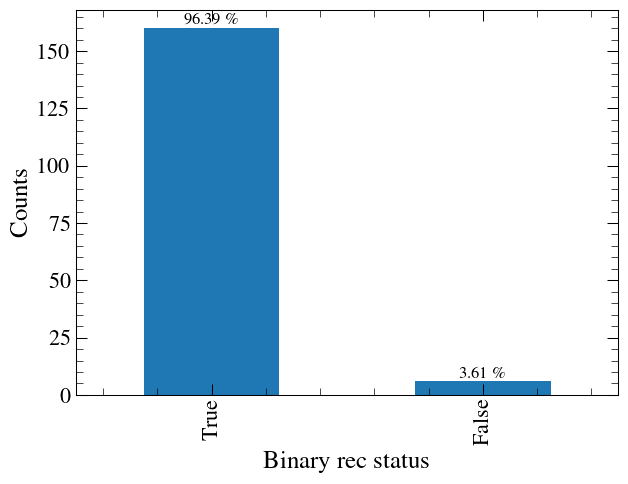

In [8]:
bina = df.loc[df["type"] == "Binary"]
stats = bina["status"].value_counts()
percents = stats / stats.sum() * 100
bad = bina.loc[bina["status"] == False]
# Plot
stats.plot.bar(xlabel="Binary rec status", ylabel="Counts")
for i, counts in enumerate(stats.values):
    plt.text(i, counts, fr"{percents[i]:.2f} \%", ha="center", va="bottom", fontdict=dict(size=12))

print(f"Binary proportion: {len(bina) / len(proc) * 100:0.2f}")

In [7]:
ok_bina = bina.loc[bina["status"] == True]
eff = un.ufloat(len(ok_bina), math.sqrt(len(ok_bina)))
eff /= len(bina)
eff *= 100
print(f"Efficiency : {eff:.2uS}")

Efficiency : 96.4(7.6)


There is a small amount of unreconstructed events. The next figure shows those events.

In [5]:
root = uproot.open("../../../Macros/PID/Outputs/sidesil.root:SimpleTree").arrays(library="pd")
root["fRun"] = root["fRun"].astype(int)
root["fEntry"] = root["fEntry"].astype(int)

# Fill tpc data
dataman = phys.DataManInterface("../../../configs/data.conf", "tpc", (155, 175))
tpc = r.ActRoot.TPCData() #type: ignore
dataman.set_branch_address("TPCData", tpc)
for idx in bad.index:
    run = bad.at[idx, "run"]
    entry = bad.at[idx, "entry"]
    dataman.get_run_entry(run, entry)
    bad.at[idx, "tpc"] = phys.TPCInterface(tpc)

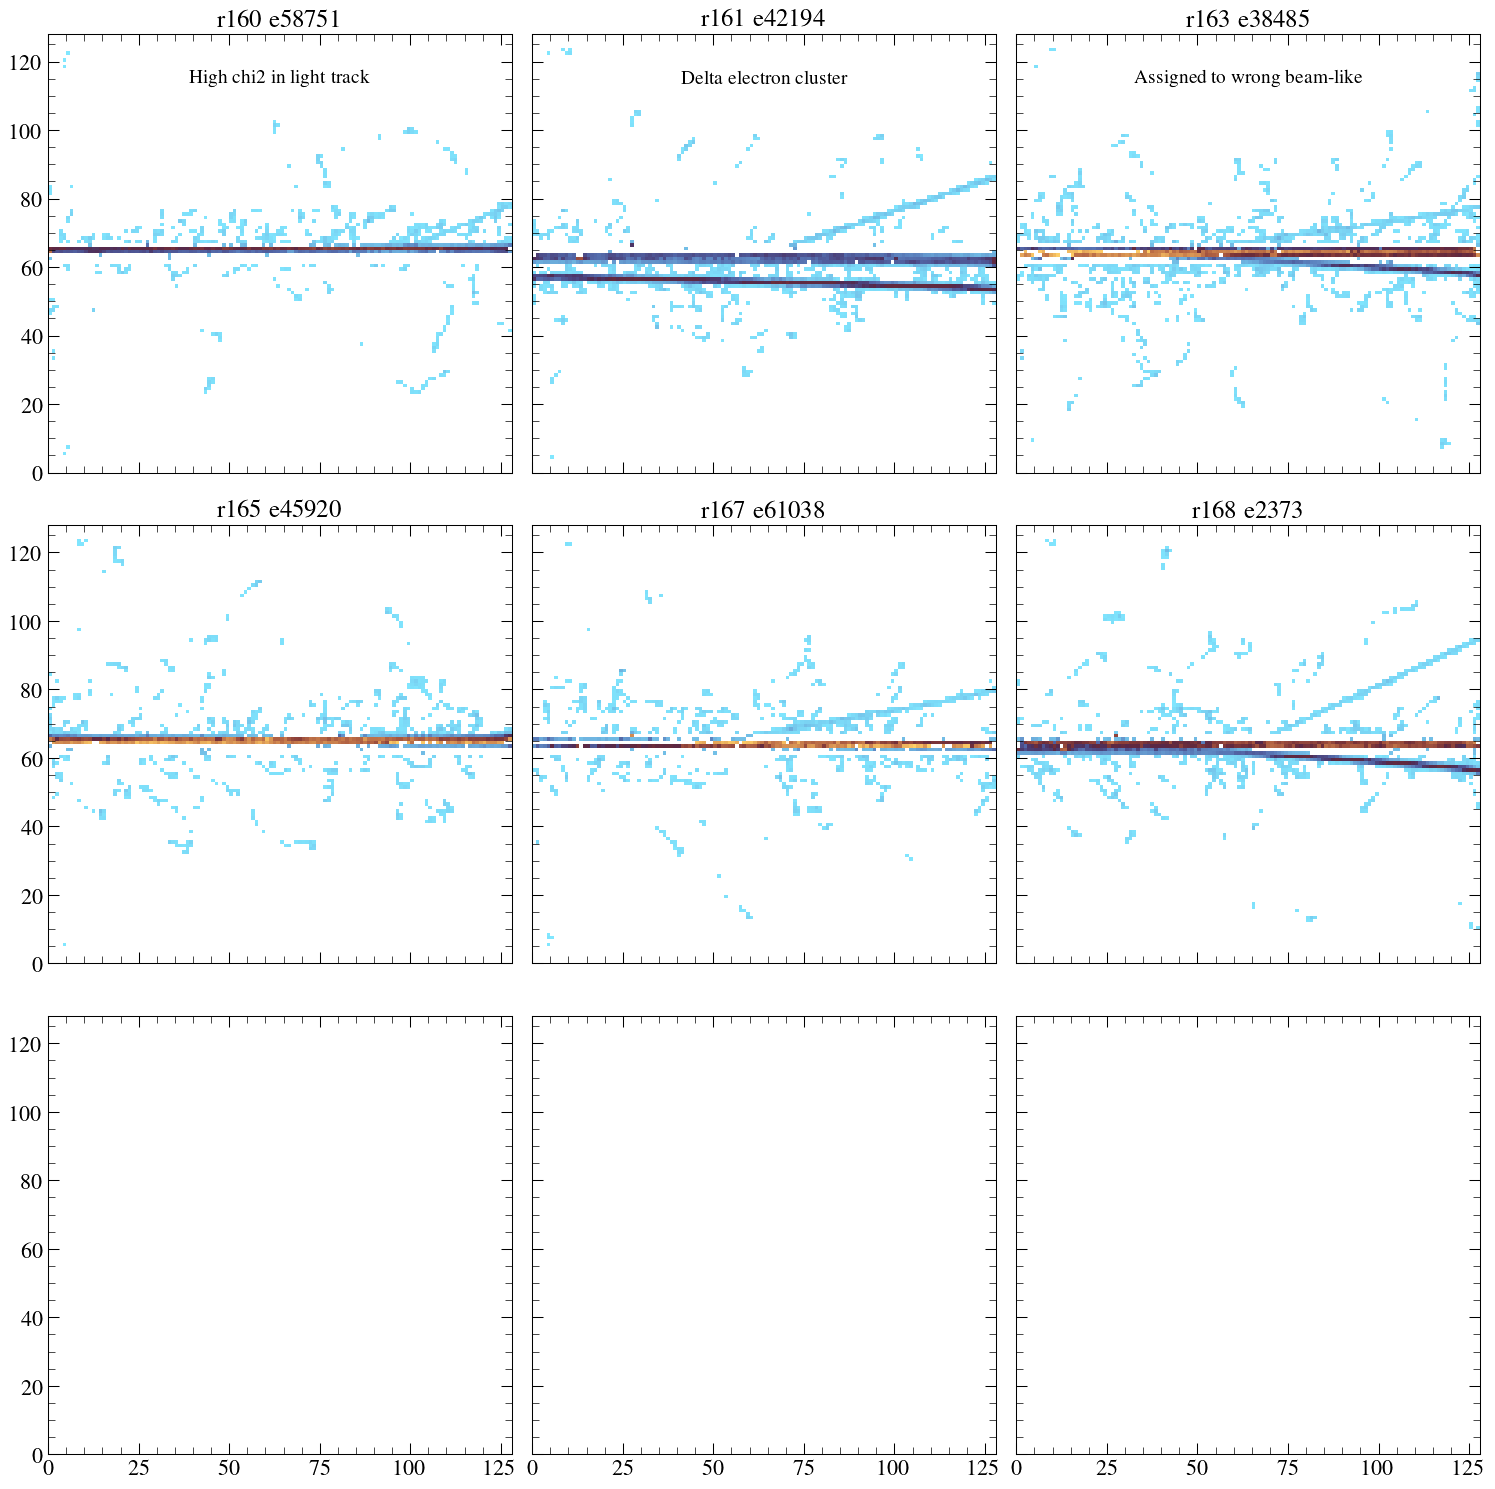

In [6]:
# Plot
n = 3
m = 3

to_plot = bad.index
labels = ["High chi2 in light track", "Delta electron cluster", "Assigned to wrong beam-like"]

fig, axs = plt.subplots(n, m, figsize=(15, 15), sharex=True, sharey=True)
for i, index in enumerate(to_plot):
    ax = axs.flatten()[i]
    run = bad.at[index, "run"]
    entry = bad.at[index, "entry"]
    # TPC
    bad.at[index, "tpc"].plot(proj="xy", ax=ax, cbar=False)
    ax.set_title(fr"r{run} e{entry}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    if i < len(labels):
        ax.annotate(labels[i], xy=(0.5, 0.9), xycoords="axes fraction", ha="center", va="center", fontsize=14)


fig.tight_layout()
